In [9]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
from typing import Dict, List, Tuple, Optional
import warnings
import talib as ta
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import os

def _ensure_datetime(series: pd.Series) -> pd.Series:
    # 若已是datetime类型，直接返回
    if pd.api.types.is_datetime64_any_dtype(series):
        return series
    
    # 安全转换为数值类型（非数值转为NaN，避免astype直接报错）
    s = pd.to_numeric(series, errors='coerce')
    
    # 检查是否存在无法转换的非数值
    if s.isna().any():
        warnings.warn("序列中包含无法转换为数值的元素，已自动转为NaT")
    
    # 避免空序列导致的判断错误
    if s.empty:
        return pd.Series([], dtype='datetime64[ns]')
    
    # 基于2025年前后的合理时间戳范围设置阈值（单位：对应单位的数量）
    # 参考：2025年的时间戳约为 1.7e9秒 ≈ 1.7e12毫秒 ≈ 1.7e15微秒 ≈ 1.7e18纳秒
    ns_threshold = 1e17  # 纳秒级阈值（约317年，覆盖合理时间范围）
    us_threshold = 1e14  # 微秒级阈值（约317年）
    ms_threshold = 1e11  # 毫秒级阈值（约317年）
    s_abs = s.abs()  # 用绝对值判断量级，保留原始符号用于转换（支持负时间戳）
    
    # 按any()逻辑判断单位（只要有一个元素满足阈值就用对应单位）
    if (s_abs > ns_threshold).any():
        return pd.to_datetime(s, unit='ns', errors='coerce')
    elif (s_abs > us_threshold).any():
        return pd.to_datetime(s, unit='us', errors='coerce')
    elif (s_abs > ms_threshold).any():
        return pd.to_datetime(s, unit='ms', errors='coerce')
    else:
        return pd.to_datetime(s, unit='s', errors='coerce')

In [17]:
def build_dollar_bars(
    trades: pd.DataFrame,
    dollar_threshold: float,
) -> pd.DataFrame:
    """
    生成dollar bars，确保bar_id连续递增。
    
    改进点：
    1. 重构bar_id计算逻辑，通过跟踪累积成交额确保连续
    2. 避免因单笔大额交易导致的bar_id跳跃
    3. 仅过滤最后一个不完整的bar（若存在）
    """
    trades['time'] = _ensure_datetime(trades['time'])
    trades = trades.sort_values('time').reset_index(drop=True)
    df = trades.copy()
    # 处理时间列和排序
    # df['time'] = _ensure_datetime(df['time'])
    # df = df.sort_values('time').reset_index(drop=True)
    
    # 计算成交额（quote_qty）
    if 'quote_qty' not in df.columns or df['quote_qty'].isna().all():
        df['quote_qty'] = df['price'] * df['qty']
    
    # 标记交易方向
    df['trade_sign'] = np.where(df['is_buyer_maker'], -1, 1)
    df['buy_qty'] = df['qty'].where(df['trade_sign'] > 0, 0.0)
    df['sell_qty'] = df['qty'].where(df['trade_sign'] < 0, 0.0)
    
    # 向量化生成 bar_id：用累计成交额除以阈值（减去微小 eps 保证等于阈值时仍归当前 bar）
    prices = df['price'].to_numpy(dtype=float)
    qtys = df['qty'].to_numpy(dtype=float)
    quotes = df['quote_qty'].to_numpy(dtype=float)
    signs = np.where(df['is_buyer_maker'].to_numpy(), -1.0, 1.0)

    cs_quote_all = np.cumsum(quotes)
    # 关键修正：使用“当前成交前”的累计额决定 bar_id，保证当前成交仍归属当前 bar
    cs_quote_prev = cs_quote_all - quotes
    bar_ids = np.floor(cs_quote_prev / float(dollar_threshold)).astype(int)
    df['bar_id'] = bar_ids

    df = df.reset_index().rename(columns={'index': 'original_index'})
    # 分组聚合
    agg = {
        'time': ['first', 'last'],
        'price': ['first', 'max', 'min', 'last'],
        'qty': 'sum',
        'quote_qty': 'sum',
        'buy_qty': 'sum',
        'sell_qty': 'sum',
        'original_index': ['first', 'last']
    }
    
    g = df.groupby('bar_id', sort=True).agg(agg)
    
    # 展平列名
    g.columns = [
        'start_time', 'end_time',
        'open', 'high', 'low', 'close',
        'volume', 'dollar_value',
        'buy_volume', 'sell_volume',
        'start_trade_idx', 
        'end_trade_idx'
    ]

    # 交易笔数（每个 bar 的 size）
    g['trades'] = df.groupby('bar_id').size().values
    
    # 前缀和快照采用向量化一次性计算
    # 数量/金额/加权价
    csum_qty = np.cumsum(qtys)
    csum_signed_qty = np.cumsum(signs * qtys)
    csum_quote = cs_quote_all
    csum_signed_quote = np.cumsum(signs * quotes)
    csum_pxqty = np.cumsum(prices * qtys)
    # 波动相关：对数收益、绝对值与双乘
    logp = np.log(prices)
    r = np.diff(logp)
    ret2 = np.r_[0.0, r * r]
    abs_r = np.r_[0.0, np.abs(r)]
    bp_core = np.r_[0.0, np.r_[0.0, abs_r[1:] * abs_r[:-1]]]
    csum_ret2 = np.cumsum(ret2)
    csum_abs_r = np.cumsum(abs_r)
    csum_bpv = np.cumsum(bp_core)

    end_idx = g['end_trade_idx'].to_numpy(dtype=int)
    g['cs_qty'] = csum_qty[end_idx]
    g['cs_quote'] = csum_quote[end_idx]
    g['cs_signed_qty'] = csum_signed_qty[end_idx]
    g['cs_signed_quote'] = csum_signed_quote[end_idx]
    g['cs_pxqty'] = csum_pxqty[end_idx]
    g['cs_ret2'] = csum_ret2[end_idx]
    g['cs_abs_r'] = csum_abs_r[end_idx]
    g['cs_bpv'] = csum_bpv[end_idx]
    
    
    # 仅过滤最后一个可能不完整的bar（若其成交额不足阈值）
    if not g.empty and g.iloc[-1]['dollar_value'] < dollar_threshold:
        g = g.iloc[:-1]
    
    # 重置bar_id为连续整数（避免因过滤最后一个bar导致的断档）
    g = g.reset_index(drop=True)
    g['bar_id'] = g.index
    
    return g
 

In [25]:
def generate_date_range(start_date, end_date):    
    start = datetime.strptime(start_date, '%Y-%m-%d')
    end = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_list = []
    current = start
    while current <= end:
        date_list.append(current.strftime('%Y-%m-%d'))
        current += timedelta(days=1)
    return date_list

raw_df = []
daily = True
start_date = '2025-06-01'
end_date = '2025-06-20'
dollar_threshold=10000*60000
dollar_threshold_str = str(dollar_threshold).replace("*", "_")
trades_zip_path = None

# 聚合成dollar bar的数据
bar_zip_path = None

if daily:
    trades_zip_path = f'/Users/aming/project/python/crypto-trade/output/trades-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-{start_date}-{end_date}-{dollar_threshold_str}.zip'
    date_list = generate_date_range(start_date, end_date)
    for date in date_list:
        raw_df.append(pd.read_csv(f'/Volumes/Ext-Disk/data/futures/um/daily/trades/ETHUSDT/ETHUSDT-trades-{date}.zip'))
else:
    trades_zip_path = f'/Volumes/Ext-Disk/data/futures/um/monthly/trades/ETHUSDT/ETHUSDT-trades-2025-05.zip'
    bar_zip_path = f'/Users/aming/project/python/crypto-trade/output/bars-2025-05-01-2025-06-01-{dollar_threshold_str}.zip'
    raw_df.append(pd.read_csv(trades_zip_path))

trades_df = pd.concat(raw_df, ignore_index=True)

In [29]:
if bar_zip_path is not None and os.path.exists(bar_zip_path):
    bars = pd.read_csv(bar_zip_path)
else:
    bars = build_dollar_bars(trades_df, dollar_threshold=dollar_threshold)
    os.makedirs(os.path.dirname(bar_zip_path), exist_ok=True)
    bars.to_csv(bar_zip_path, index=False,compression={'method': 'zip', 'archive_name': 'bars.csv'})

<Axes: >

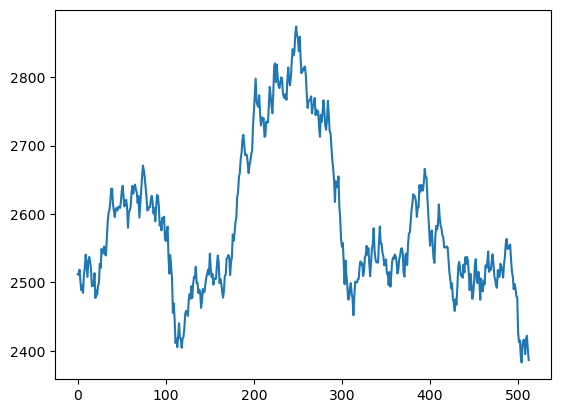

In [31]:
bars.close.plot()

<Axes: >

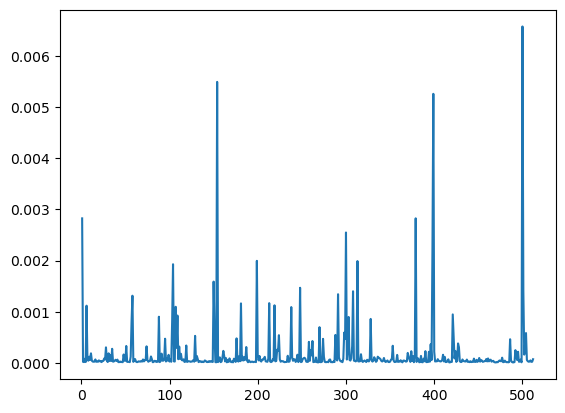

In [36]:
bars.cs_bpv.diff().plot()